# LangGraph 챗봇 테스트 (V5)

이 노트북은 새로 구현된 `graph.py`의 챗봇 로직을 테스트합니다.

## V5 주요 기능
- **LLM 기반 의도 분류**: 새 검색 / 이전 결과 참조 / 상세 질문 / 일반 대화 구분
- **대화 맥락 유지**: 이전 검색 결과 및 선택된 공고 기억
- **조건부 라우팅**: 의도에 따라 다른 처리 흐름

## 실행 방법
1. 커널 재시작 (Restart Kernel)
2. 셀들을 순서대로 실행
3. 대화형 테스트에서 다양한 질문 시도

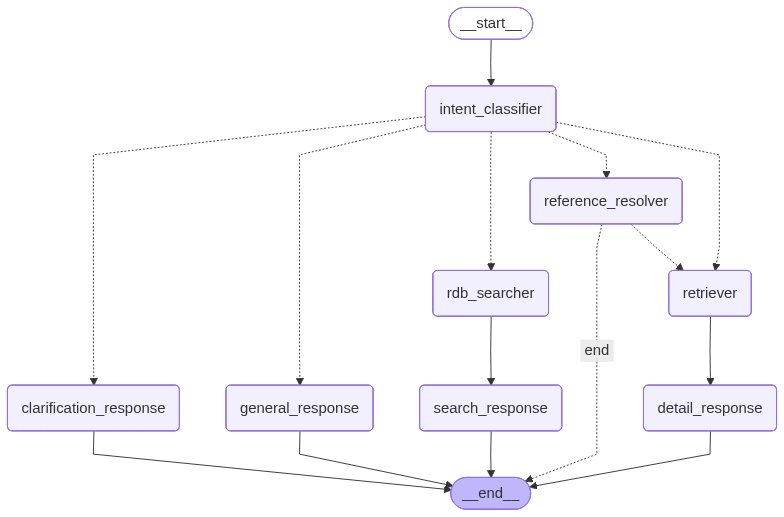

In [2]:
from chatbot.graph import create_chatbot_graph
create_chatbot_graph()

In [1]:
# 1. Django 환경 설정
import os
import sys
import django

# 비동기 컨텍스트에서 Django ORM 사용 허용
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

# Django 프로젝트 경로 설정
project_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_path not in sys.path:
    sys.path.append(project_path)

os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'config.settings')
django.setup()

print(f"Django 환경 설정 완료: {project_path}")

Django 환경 설정 완료: /Users/kimjm/Desktop/ZIP-FIT-2/zf_django


In [2]:
# 2. 모듈 임포트 (reload로 최신 코드 반영)
from importlib import reload
import chatbot.graph as graph_module
reload(graph_module)

from chatbot.graph import chat, get_chatbot, ChatbotConfig, Intent

# 싱글톤 초기화
graph_module._chatbot = None

print("챗봇 모듈 로드 완료 (V5)")
print(f"- LLM 모델: {ChatbotConfig.LLM_MODEL}")
print(f"- 지역: {ChatbotConfig.REGIONS}")
print(f"- 상태: {ChatbotConfig.STATUSES}")

챗봇 모듈 로드 완료 (V5)
- LLM 모델: gpt-4o-mini
- 지역: ['서울특별시', '경기도']
- 상태: ['접수중', '공고중']


In [ ]:
# 3. DB 데이터 현황 확인
from chatbot.models import AnncAll, DocChunks
from django.db.models import Count

print("=" * 50)
print("DB 데이터 현황")
print("=" * 50)

print(f"\n전체 공고 수: {AnncAll.objects.count()}건")
print(f"전체 청크 수: {DocChunks.objects.count()}건")

print("\n[지역별 공고 수]")
for r in AnncAll.objects.values('annc_region').annotate(cnt=Count('annc_id')):
    print(f"  - {r['annc_region']}: {r['cnt']}건")

print("\n[상태별 공고 수]")
for s in AnncAll.objects.values('annc_status').annotate(cnt=Count('annc_id')):
    print(f"  - {s['annc_status']}: {s['cnt']}건")

print("\n[전체 공고 목록]")
for a in AnncAll.objects.all():
    print(f"  [{a.annc_id}] {a.annc_title[:50]}... | {a.annc_region} | {a.annc_status}")

In [ ]:
# 디버그: 각 공고별 청크 수 확인
from chatbot.models import AnncAll, DocChunks

print("=" * 60)
print("공고별 청크 현황")
print("=" * 60)

for annc in AnncAll.objects.all():
    chunk_count = DocChunks.objects.filter(annc_id=annc.annc_id).count()
    print(f"\n[공고 ID: {annc.annc_id}] {annc.annc_title[:50]}...")
    print(f"  - 지역: {annc.annc_region} | 상태: {annc.annc_status}")
    print(f"  - 청크 수: {chunk_count}개")
    
    if chunk_count == 0:
        print("  ⚠️ 청크가 없습니다! RAG 검색 불가")

In [3]:
# 4. 대화 흐름 테스트 (맥락 유지 확인) - 디버그 강화
print("=" * 60)
print("대화 흐름 테스트 - 맥락 유지 확인")
print("=" * 60)

# 세션 상태 초기화
session = {}

# 대화 시나리오
conversation = [
    "안녕하세요",
    "접수중인 공고 알려줘",
    "1번 공고 신청자격 알려줘",
    "신청기간은 언제야?",
    "2번 공고는 뭐야?",
]

for i, q in enumerate(conversation, 1):
    print(f"\n[{i}] 사용자: {q}")
    result = chat(q, session)
    
    # 세션 상태 디버그
    prev_session = session.copy()
    session = result.get('session_state', session)
    
    answer = result['answer']
    if len(answer) > 400:
        print(f"    챗봇: {answer[:400]}...")
    else:
        print(f"    챗봇: {answer}")
    
    # 디버그 정보
    debug = result.get('debug_info', {})
    if 'intent_result' in debug:
        intent = debug['intent_result'].get('intent', 'unknown')
        ref_idx = debug['intent_result'].get('reference_index', '-')
        print(f"    [의도: {intent}, 참조인덱스: {ref_idx}]")
    
    # 세션 상태 출력
    prev_anncs = session.get('prev_anncs', [])
    selected = session.get('selected_annc')
    print(f"    [세션] prev_anncs: {len(prev_anncs)}개, selected: {selected.get('annc_id') if selected else None}")
    
    if prev_anncs:
        for idx, a in enumerate(prev_anncs, 1):
            print(f"      - {idx}번: [{a.get('annc_id')}] {a.get('annc_title', '')[:30]}...")
    
    print("-" * 60)

대화 흐름 테스트 - 맥락 유지 확인

[1] 사용자: 안녕하세요
    챗봇: 안녕하세요! 주택 공고에 대해 궁금한 점이 있으신가요? 지역이나 상태에 따라 원하는 주택 공고를 검색해드릴 수 있어요. 어떤 정보가 필요하신지 말씀해주시면 도와드릴게요!
    [의도: general_chat, 참조인덱스: -]
    [세션] prev_anncs: 0개, selected: None
------------------------------------------------------------

[2] 사용자: 접수중인 공고 알려줘
    챗봇: 총 **2개**의 공고를 찾았습니다.

1. **수원당수 A-5블록 신혼희망타운 행복주택 입주자 모집공고**
   - 상태: 접수중 | 지역: 경기도
2. **서울 청년 예술인 특화형 매입임대주택 [그루하우스 서대문] 예비입주자 모집공고문[25.11.19]**
   - 상태: 접수중 | 지역: 서울특별시

궁금한 공고 번호를 말씀해주시면 자세한 정보를 알려드릴게요. (예: "1번 공고 알려줘")
    [의도: new_search, 참조인덱스: -]
    [세션] prev_anncs: 2개, selected: None
      - 1번: [5] 수원당수 A-5블록 신혼희망타운 행복주택 입주자 모집공...
      - 2번: [1] 서울 청년 예술인 특화형 매입임대주택 [그루하우스 서대...
------------------------------------------------------------

[3] 사용자: 1번 공고 신청자격 알려줘
    챗봇: 수원당수 A-5블록 신혼희망타운 행복주택의 신청자격은 다음과 같습니다:

- 입주자(세대구성원 전원 포함)는 입주자모집공고일 현재부터 임대차계약 종료일까지 무주택세대구성원이어야 합니다.
- 주택공급신청자는 성년자(자녀를 부양하거나 직계존속의 사망, 실종신고 및 행방불명 등으로 형제자매를 부양해야 하는 미성년자 포함)인 무주택세대구성원을 말하며, 예비신혼부부와 한부모가족은

In [4]:
# 5. 엣지 케이스 테스트
print("=" * 60)
print("엣지 케이스 테스트")
print("=" * 60)

edge_cases = [
    ("이전 목록 없이 참조", "1번 공고 알려줘", {}),
    ("없는 지역 검색", "부산 공고 보여줘", {}),
    ("없는 키워드 검색", "노인 주택 있어?", {}),
    ("모호한 질문", "그거 알려줘", {}),
]

for name, question, state in edge_cases:
    print(f"\n[테스트: {name}]")
    print(f"질문: {question}")
    result = chat(question, state)
    print(f"답변: {result['answer'][:300]}..." if len(result['answer']) > 300 else f"답변: {result['answer']}")
    print("-" * 60)

엣지 케이스 테스트

[테스트: 이전 목록 없이 참조]
질문: 1번 공고 알려줘
답변: 어떤 공고를 찾고 계신가요? 먼저 검색을 해주세요.

**예시:**
- '서울 공고 보여줘'
- '접수중인 공고 알려줘'
- '청년 임대 공고'
------------------------------------------------------------

[테스트: 없는 지역 검색]
질문: 부산 공고 보여줘
답변: 총 **4개**의 공고를 찾았습니다.

1. **[정정공고]양주회천 A25BL 영구임대주택 입주자 모집공고**
   - 상태: 공고중 | 지역: 경기도
2. **수원당수 A-5블록 신혼희망타운 행복주택 입주자 모집공고**
   - 상태: 접수중 | 지역: 경기도
3. **서울 청년 예술인 특화형 매입임대주택 [그루하우스 서대문] 예비입주자 모집공고문[25.11.19]**
   - 상태: 접수중 | 지역: 서울특별시
4. **양주시, 동두천시 행복주택 상시모집[선착순동호지정, 입주자격완화, 선계약후검증]**
   - 상태: 공고중 |...
------------------------------------------------------------

[테스트: 없는 키워드 검색]
질문: 노인 주택 있어?
답변: 죄송합니다. [키워드: 노인, 상태: 접수중, 공고중] 조건에 맞는 공고를 찾지 못했습니다.

**검색 팁:**
- '서울 공고 보여줘' - 지역별 검색
- '접수중인 공고' - 상태별 검색
- '청년 임대' - 키워드 검색
------------------------------------------------------------

[테스트: 모호한 질문]
질문: 그거 알려줘
답변: 질문을 잘 이해하지 못했습니다. 다시 말씀해주시겠어요?

**사용 예시:**
- '서울 공고 보여줘' - 공고 검색
- '1번 공고 알려줘' - 상세 정보
- '신청자격이 뭐야?' - 선택한 공고 질문
-------------------------------------------

In [ ]:
# 6. 대화형 테스트 루프
print("="* 60)
print("대화형 챗봇 테스트")
print("'exit' 또는 'quit' 입력시 종료")
print("'reset' 입력시 대화 초기화")
print("'debug' 입력시 현재 세션 상태 출력")
print("="* 60)

session_state = {}

while True:
    try:
        question = input("\n사용자: ")
    except EOFError:
        print("종료합니다.")
        break
        
    if question.lower() in ['exit', 'quit']:
        print("종료합니다.")
        break
    
    if question.lower() == 'reset':
        session_state = {}
        print("대화가 초기화되었습니다.")
        continue
    
    if question.lower() == 'debug':
        print("\n[현재 세션 상태]")
        print(f"  - 대화 기록 수: {len(session_state.get('chat_history', []))}")
        print(f"  - 이전 공고 수: {len(session_state.get('prev_anncs', []))}")
        selected = session_state.get('selected_annc')
        if selected:
            print(f"  - 선택된 공고: {selected.get('annc_title', 'N/A')[:40]}...")
        else:
            print(f"  - 선택된 공고: 없음")
        continue
    
    if not question.strip():
        continue
    
    try:
        result = chat(question, session_state)
        print(f"\n챗봇: {result['answer']}")
        
        if 'session_state' in result:
            session_state = result['session_state']
            
    except Exception as e:
        print(f"\n오류 발생: {e}")
        import traceback
        traceback.print_exc()